# Grassland

In [1]:
import sys
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import rasterio as rio
from rasterio.mask import mask
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from glob import glob


import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import matplotlib.pyplot as plt
# %matplotlib inline

import utils
import util_preprocess

In [2]:
# Get abosolute path of the current folder
FPATH = 'D:/mongolia/GITHUB/features'

# Get abosolute output path of te current folder
OUTPUT = 'D:/mongolia/mongolia_ml_model/output/'

target = 'class'

# Random seed
# The random seed
random_seed = 42

# Set random seed in numpy
np.random.seed(random_seed)

In [3]:
# Load data to VRT for processing 
files = sorted(glob(f'{FPATH}/*/*.tif'))

# Load data data for processing 
# files = sorted(glob(f'{FPATH}/fourier/*.tif'))
array_stack, meta_data = es.stack(files, nodata=0.0)

# Process spfea features, get the width, height and number of bands
n = array_stack.shape[0]
print (n) # number of bands
h = array_stack.shape[1]
print (h) # height
w = array_stack.shape[2]
print (w) # width

31
2379
2490


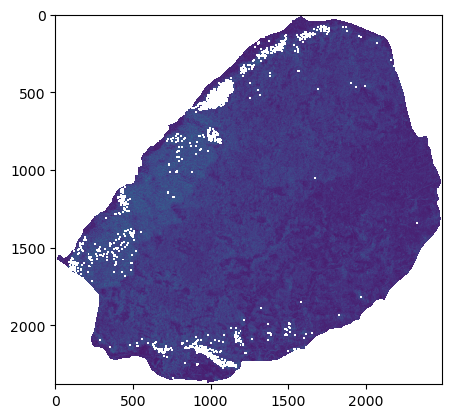

In [4]:
#plot 
plt.imshow(array_stack[9])

In [5]:
bandname = []
for file in files:
    head, tail = os.path.split(file)
    col_names=tail[:-4]
    bandname.append(col_names)


# Make dataframe
df_data=utils.make_data_frame(array_stack, bandname)
df_data.head()
# df['Easting']=utils.pixel_id_to_lon(img_gt, np.arange(df.shape[0])%img_arr.shape[2])
# df['Northing']=utils.pixel_id_to_lat(img_gt, np.repeat(np.arange(img_arr.shape[1]), img_arr.shape[2]))
# print("These columns contain nan:", df.columns[df.isna().any()].tolist())
# df['uid'] = np.arange(start=0,stop = len(df), dtype=int)

(31, 2379, 2490)


,fourier_sc10_mean,fourier_sc10_variance,fourier_sc200_mean,fourier_sc40_mean,fourier_sc40_variance,gabor_sc10_mean,gabor_sc10_variance,gabor_sc40_mean,gabor_sc40_variance,hog_sc10_max,...,lsr_sc40_line_mean,mean_sc10_mean,mean_sc40_variance,orb_sc10_kurtosis,orb_sc10_mean,orb_sc10_variance,orb_sc200_variance,orb_sc40_max,orb_sc40_mean,orb_sc40_variance
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
PATH_TR=glob(f'D:/mongolia/mongolia_ml_model/train_mgl_2/*.tif')

train_array, meta_data = es.stack(PATH_TR, nodata=-2147483648)
train_array = train_array.astype(int)

print(train_array.shape)

(unique, counts) = np.unique(train_array, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

(2, 2379, 2490)


array([[-2147483648,    11843450],
       [          1,         626],
       [          2,         294],
       [          3,         110],
       [          4,         284],
       [          5,         446],
       [          6,        1098],
       [          7,         986],
       [          8,         126]], dtype=int64)

In [7]:
tr_name = ["class"]
tr_img_data = train_array.flatten()
df_train = pd.DataFrame(tr_img_data, columns=tr_name)
df_train.head()
df_train['class'].unique()

array([-2147483648,           3,           1,           7,           2,
                 6,           5,           8,           4])

In [8]:
# df_train = df_train.loc[df_train['class'] != -2147483648 ]
# print(df_train.shape)
# df_train.head()
# df_train['class'].unique()

In [9]:
# concat trainset and data
data_concat = pd.concat([df_train, df_data], axis=1)
print (data_concat.shape)
data_concat = data_concat.dropna(axis=0)

(11847420, 32)


In [10]:
df_full = data_concat.loc[data_concat['class'] != -2147483648 ]
print(df_full.shape)
df_full.head()
df_full['class'].unique()

(1697, 32)


array([3, 1, 7, 2, 6, 5, 8, 4])

In [11]:
# Divide the training data into training (80%) and testing (20%)
df_train, df_test = train_test_split(df_full, train_size=0.80, random_state=random_seed)
# Reset the index
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

# Divide the training data into training (80%) and validation (20%)
df_train, df_val = train_test_split(df_train, train_size=0.80, random_state=random_seed)
# Reset the index
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)

print('df_train', df_train.shape)
print('df_val', df_val.shape)
print('df_test', df_test.shape)

df_train (1085, 32)
df_val (272, 32)
df_test (340, 32)


In [12]:
# Handling missing data
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

## Check and count for NaN values by column in the table
if df.isnull().any().any():
    for colomn in list(df.columns.values):
        if df[colomn].isnull().any():
            print ("Column '"+str(colomn)+"' have "+str(df[colomn].isnull().sum())+" NULL values")
else: print ("No missing values in dataframe") 
        
## Check and count for Inf values by column in the table
if np.isinf(df).any().any():
    for colomn in list(df.columns.values):
        if np.isinf(df[colomn]).any():
            print ("Column '"+str(colomn)+"' have "+str(np.isinf(df[colomn]).sum())+" Infinite values")
else: print ("No infinite values in dataframe") 





No missing values in dataframe
No infinite values in dataframe


In [13]:
# df = df.dropna(axis=0)

In [14]:
# # Call nan_checker on df
# df_nan = util_preprocess.nan_checker(df)

# # Print df_nan
# df_nan
# # %%
# # Print the unique data type of variables with NaN
# pd.DataFrame(df_nan['dtype'].unique(), columns=['dtype'])

# # %%
# # Get the variables with missing values, their proportion of missing values and data type
# df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# # Print df_miss
# df_miss

In [15]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]
# print("df_train:",df_train.isnull())
print("df_train shape:",df_train.shape)

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]
# print("df_val:",df_val.isnull())
print("df_val shape:",df_val.shape)

# Separating the test data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]
# print("df_test:",df_test.isnull())
print("df_test shape:",df_test.shape)

df_train shape: (1085, 32)
df_val shape: (272, 32)
df_test shape: (340, 32)


In [16]:
# # Imputing missing values
# from sklearn.impute import SimpleImputer

# # If there are missing values
# if len(df_miss['var']) > 0:
#     # The SimpleImputer
#     si = SimpleImputer(missing_values=np.nan, strategy='mean')

#     # Impute the variables with missing values in df_train, df_val and df_test 
#     df_train[df_miss['var']] = si.fit_transform(df_train[df_miss['var']])
#     df_val[df_miss['var']] = si.transform(df_val[df_miss['var']])
#     df_test[df_miss['var']] = si.transform(df_test[df_miss['var']])

In [17]:
# Separating the training, validation and test data
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the test data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

In [18]:
# Get the feature matrix
X_train = df_train[np.setdiff1d(df_train.columns, [target])].values
X_val = df_val[np.setdiff1d(df_val.columns, [target])].values
X_test = df_test[np.setdiff1d(df_test.columns, [target])].values

# Get the target vector
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

In [19]:
# The StandardScaler
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_val = ss.transform(X_val)

# Standardize the test data
X_test = ss.transform(X_test)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

models = {'lr': LogisticRegression(class_weight='balanced', random_state=random_seed),
          'mlpc': MLPClassifier(early_stopping=True, random_state=random_seed),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=random_seed),
          'hgbc': HistGradientBoostingClassifier(random_state=random_seed)}

c:\Users\mowus\.conda\envs\mongolia\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [21]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [22]:
X_train_val, y_train_val, ps = util_preprocess.get_train_val_ps(X_train, y_train, X_val, y_val)

param_grids = {}

In [23]:
# The parameter grid of tol
tol_grid = [10 ** -7, 10 ** -5, 10 ** -4, 10 ** -3]

# The parameter grid of C
C_grid = [0.1, 1, 11, 13]

# Update param_grids
param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid}]

In [24]:
# The grids for alpha
alpha_grids = [10 ** i for i in range(-5, -3)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-3, 2)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

In [25]:
# The grids for min_samples_split
min_samples_split_grids = [21, 23, 30, 27, 30]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 3, 7, 9, 11]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

In [26]:
# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 27]

# Update param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids}]

In [27]:
# Creating the directory for the cv results produced by GridSearchCV
# Make directory
directory = os.path.dirname('D:/mongolia/mongolia_ml_model/output/mgl_map')
if not os.path.exists(directory):
    os.makedirs(directory)

In [28]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# For each model
for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=-2,
                      cv=ps,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_val, y_train_val)
    
    # Update best_score_params_estimator_gs
    best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf='D:/mongolia/mongolia_ml_model/output/GridSearch' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

c:\Users\mowus\.conda\envs\mongolia\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,best_score,best_param,best_estimator
0,0.951332,"{'model__C': 11, 'model__tol': 1e-07}","(LogisticRegression(C=11, class_weight='balanc..."
1,0.947595,"{'model__min_samples_leaf': 7, 'model__min_sam...","((DecisionTreeClassifier(max_features='sqrt', ..."
2,0.943721,"{'model__learning_rate': 0.1, 'model__min_samp...",(HistGradientBoostingClassifier(random_state=42))
3,0.925480,"{'model__alpha': 1e-05, 'model__learning_rate_...","(MLPClassifier(alpha=1e-05, early_stopping=Tru..."


In [29]:
# Get the best_score, best_params and best_estimator obtained by GridSearchCV
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]
best_params_gs

{'model__C': 11, 'model__tol': 1e-07}

In [30]:
# Make directory
directory = os.path.dirname('D:/mongolia/mongolia_ml_model/output/submission/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [31]:
# Get the prediction on the test data using the best model
y_test_pred = best_estimator_gs.predict(X_test)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_test_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_test_pred))

=== Confusion Matrix ===
[[ 63   0   0   0   0   0   0   0]
 [  0  12   1   1   0   0   0   0]
 [  0   0   8   0   1   0   0   0]
 [  0   1   0  12   0   0   1   0]
 [  0   0   0   0  46   0   0   0]
 [  1   0   0   1   0 105   0   0]
 [  0   0   0   0   0   1  68   0]
 [  0   0   0   0   0   0   0  18]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.98      1.00      0.99        63
           2       0.92      0.86      0.89        14
           3       0.89      0.89      0.89         9
           4       0.86      0.86      0.86        14
           5       0.98      1.00      0.99        46
           6       0.99      0.98      0.99       107
           7       0.99      0.99      0.99        69
           8       1.00      1.00      1.00        18

    accuracy                           0.98       340
   macro avg       0.95      0.95      0.95       340
weighted avg       0.98      0.98      0.98       340



In [33]:
# # Inference

# folders = ['fourier_sub', 'gabor_sub', 'hog_sub', 'mean_sub', 'lsr_sub', 'lbpm_sub', 'orb_sub']

# files = sorted(glob(f'{FPATH}/{folders[0]}/*.tif'))
# fourier_array_stack, meta_data = es.stack(files, nodata=0.0)
# fourier_array_stack = fourier_array_stack.reshape(fourier_array_stack.shape[0], -1)
# fourier_array_stack = ss.fit_transform(fourier_array_stack)
# print(fourier_array_stack.shape)

# files = sorted(glob(f'{FPATH}/{folders[1]}/*.tif'))
# gabor_array_stack, meta_data = es.stack(files, nodata=0.0)
# gabor_array_stack = gabor_array_stack.reshape(gabor_array_stack.shape[0], -1)
# gabor_array_stack = ss.fit_transform(gabor_array_stack)
# print(gabor_array_stack.shape)

# files = sorted(glob(f'{FPATH}/{folders[2]}/*.tif'))
# hog_array_stack, meta_data = es.stack(files, nodata=0.0)
# hog_array_stack = hog_array_stack.reshape(hog_array_stack.shape[0], -1)
# hog_array_stack = ss.fit_transform(hog_array_stack)
# print(hog_array_stack.shape)

# files = sorted(glob(f'{FPATH}/{folders[3]}/*.tif'))
# mean_array_stack, meta_data = es.stack(files, nodata=0.0)
# mean_array_stack = mean_array_stack.reshape(mean_array_stack.shape[0], -1)
# mean_array_stack = ss.fit_transform(mean_array_stack)
# print(mean_array_stack.shape)

# files = sorted(glob(f'{FPATH}/{folders[4]}/*.tif'))
# lsr_array_stack, meta_data = es.stack(files, nodata=0.0)
# lsr_array_stack = lsr_array_stack.reshape(lsr_array_stack.shape[0], -1)
# lsr_array_stack = ss.fit_transform(lsr_array_stack)
# print(lsr_array_stack.shape)

# files = sorted(glob(f'{FPATH}/{folders[5]}/*.tif'))
# ibpm_array_stack, meta_data = es.stack(files, nodata=0.0)
# ibpm_array_stack = ibpm_array_stack.reshape(ibpm_array_stack.shape[0], -1)
# ibpm_array_stack = ss.fit_transform(ibpm_array_stack)
# print(ibpm_array_stack.shape)

# files = sorted(glob(f'{FPATH}/{folders[6]}/*.tif'))
# orb_array_stack, meta_data = es.stack(files, nodata=0.0)
# orb_array_stack = orb_array_stack.reshape(orb_array_stack.shape[0], -1)
# orb_array_stack = ss.fit_transform(orb_array_stack)
# print(orb_array_stack.shape)

In [34]:
# data_stack_scale =np.concatenate((fourier_array_stack, gabor_array_stack, hog_array_stack, mean_array_stack, lsr_array_stack, ibpm_array_stack, orb_array_stack), axis=0)
# data_stack_scale.shape

In [70]:
# Load data to VRT for processing 
files = sorted(glob(f'{FPATH}/*/*.tif'))

array_stack, meta_data = es.stack(files)

bandname = []
for file in files:
    head, tail = os.path.split(file)
    col_names=tail[:-4]
    bandname.append(col_names)

# Make dataframe
df_data=utils.make_data_frame(array_stack, bandname)
df_data['uid'] = np.arange(start=0,stop = len(df_data), dtype=int)
df_data.head()

(31, 2379, 2490)


,fourier_sc10_mean,fourier_sc10_variance,fourier_sc200_mean,fourier_sc40_mean,fourier_sc40_variance,gabor_sc10_mean,gabor_sc10_variance,gabor_sc40_mean,gabor_sc40_variance,hog_sc10_max,...,mean_sc10_mean,mean_sc40_variance,orb_sc10_kurtosis,orb_sc10_mean,orb_sc10_variance,orb_sc200_variance,orb_sc40_max,orb_sc40_mean,orb_sc40_variance,uid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [71]:
# Handling missing data

## Check and count for NaN values by column in the table
if df_data.isnull().any().any():
    for colomn in list(df_data.columns.values):
        if df_data[colomn].isnull().any():
            print ("Column '"+str(colomn)+"' have "+str(df_data[colomn].isnull().sum())+" NULL values")
else: print ("No missing values in dataframe") 
        
## Check and count for Inf values by column in the table
if np.isinf(df_data).any().any():
    for colomn in list(df_data.columns.values):
        if np.isinf(df_data[colomn]).any():
            print ("Column '"+str(colomn)+"' have "+str(np.isinf(df_data[colomn]).sum())+" Infinite values")
else: print ("No infinite values in dataframe") 

Column 'fourier_sc10_mean' have 2215630 NULL values
Column 'fourier_sc10_variance' have 2215994 NULL values
Column 'fourier_sc200_mean' have 2203866 NULL values
Column 'fourier_sc40_mean' have 2205801 NULL values
Column 'fourier_sc40_variance' have 2205801 NULL values
Column 'gabor_sc10_mean' have 2203171 NULL values
Column 'gabor_sc10_variance' have 2203171 NULL values
Column 'gabor_sc40_mean' have 2203171 NULL values
Column 'gabor_sc40_variance' have 2203171 NULL values
Column 'hog_sc10_max' have 2205484 NULL values
Column 'hog_sc40_variance' have 2203171 NULL values
Column 'lbpm_sc10_kurtosis' have 2203171 NULL values
Column 'lbpm_sc10_max' have 2203171 NULL values
Column 'lbpm_sc10_skew' have 2203171 NULL values
Column 'lbpm_sc10_variance' have 2203171 NULL values
Column 'lbpm_sc200_max' have 2203171 NULL values
Column 'lbpm_sc40_max' have 2203171 NULL values
Column 'lbpm_sc40_skew' have 2203171 NULL values
Column 'lbpm_sc40_variance' have 2203171 NULL values
Column 'lsr_sc200_line

In [74]:
df_data['orb_sc40_mean'] = df_data['orb_sc40_mean'].fillna(value=-9999)
data_X = df_data.loc[ df_data['orb_sc40_mean'] != -9999 ]
data_uid = data_X
data_x  = data_X.drop(columns=['uid'])

data_uid['catid'] = np.arange(start=0,stop = len(data_uid), dtype=int)



C:\Users\mowus\AppData\Local\Temp\ipykernel_27536\3824564186.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_uid['catid'] = np.arange(start=0,stop = len(data_uid), dtype=int)


In [75]:
data_uid.shape

(3720109, 33)

In [76]:
# # Standardize Testing data
data_x_scale = ss.fit_transform(data_x)

from sklearn.impute import SimpleImputer

# The SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='mean')
data_x_tran = si.fit_transform(data_x_scale)


In [77]:
# PREDICTION 
pred_map = best_estimator_gs.predict(data_x_tran)


In [78]:
# Convert narray to dataframe
col_name = ['pred']
predictions_image = pd.DataFrame(pred_map, columns=col_name)
predictions_image['catid'] = np.arange(start=0,stop = len(predictions_image), dtype=int) # add a uniques id to merge
print(predictions_image.shape)
predictions_image.head()

(3720109, 2)


,pred,catid
0,4,0
1,4,1
2,4,2
3,4,3
4,4,4


In [79]:
# merge prediction to data_x (data with useful info)
map_data = predictions_image.merge(data_uid, how='inner', on='catid')
# map_data = pd.concat([predictions_image, data_x], axis=1 )
print (map_data.shape)
#
# set index for merging with big image data
map_data  = map_data.set_index('uid')
df1  = df_data.set_index('uid')

(3720109, 34)


In [80]:
# merge to bg image data
predictions_image_merge = pd.merge(df1, map_data, how='outer', right_index=True, left_index=True)


predictions_image = predictions_image_merge['pred'].values

print(predictions_image.shape)

(5923710,)


In [81]:
(unique, counts) = np.unique(predictions_image, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[1.000000e+00, 3.824870e+05],
       [2.000000e+00, 3.072200e+05],
       [3.000000e+00, 2.509640e+05],
       [4.000000e+00, 2.390720e+05],
       [5.000000e+00, 6.657910e+05],
       [6.000000e+00, 9.992930e+05],
       [7.000000e+00, 6.925430e+05],
       [8.000000e+00, 1.827390e+05],
       [         nan, 2.203601e+06]])

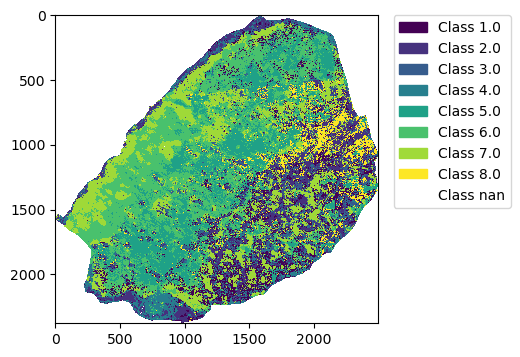

In [83]:
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

pred_map = predictions_image.reshape(h, w)


values = np.unique(pred_map.ravel())

plt.figure(figsize=(8,4))
im = plt.imshow(pred_map, interpolation='none')

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Class {l}".format(l=values[i]) ) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.show()